# FEATURE SELECTION & CROSS-VALIDATION

- 05/18/21
- onl01-dtsc-ft-022221

## Learning Objectives

- To discuss the 3 types of feature selection methods and give examples of each. 
- To discuss the use of cross-validation in our modeling process. 

# Final Project Submission

* Student name:  James Irving
* Student pace: ~~self paced / part time / full time~~: all-the-time
* Scheduled project review date/time: Now & Forever
* Instructor name: Life/Flatiron/Google

## INTRODUCTION

- Parkinson's Disease is a neurological disorder that affects coordination, balance, walking, and can also affect speech.
    - [NIA - Parkinson's Disease]( https://www.nia.nih.gov/health/parkinsons-disease#:~:text=Parkinson's%20disease%20is%20a%20brain,have%20difficulty%20walking%20and%20talking)
    
    -[Parkinson's Foundation](https://www.parkinson.org/Understanding-Parkinsons/Symptoms/Non-Movement-Symptoms/Speech-and-Swallowing-Problems)
    
- This dataset was created during the publication for > "A comparative analysis of speech signal processing algorithms for Parkinson’s disease classification and the use of the tunable Q-factor wavelet transform" 
    - https://doi.org/10.1016/j.asoc.2018.10.022

## OBTAIN

- The dataset was downloaded from https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification. 
>- "Abstract: The data used in this study were gathered from 188 patients with PD (107 men and 81 women) with ages ranging from 33 to 87 (65.1Â±10.9).
    - Data Source: 

- [Related paper](https://www.sciencedirect.com/science/article/abs/pii/S1568494618305799?via%3Dihub)
    - PDF located inside `reference` folder.
    - See Table 1 on page 9.
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE,SMOTENC


## Models & Utils
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time

In [2]:
# ## Changing Pandas Options to see full columns in previews and info
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
pd.set_option('display.float_format',lambda x: f"{x:.2f}")

In [3]:
df = pd.read_csv('data/pd_speech_features.csv',skiprows=1)
df

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_

## SCRUB

In [4]:
## null value check
nulls= df.isna().sum()
nulls.sum()

0

In [6]:
## Preview columns and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 755 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              756 non-null    int64  
 1   gender                          756 non-null    int64  
 2   PPE                             756 non-null    float64
 3   DFA                             756 non-null    float64
 4   RPDE                            756 non-null    float64
 5   numPulses                       756 non-null    int64  
 6   numPeriodsPulses                756 non-null    int64  
 7   meanPeriodPulses                756 non-null    float64
 8   stdDevPeriodPulses              756 non-null    float64
 9   locPctJitter                    756 non-null    float64
 10  locAbsJitter                    756 non-null    float64
 11  rapJitter                       756 non-null    float64
 12  ppq5Jitter                      756

## EXPLORE

### Finding Categorical Features

In [7]:
## Seeing which columns may be categorical
df.nunique()[(df.nunique() < 20)]

gender    2
class     2
dtype: int64

In [8]:
## making gender a str so its caught by pipeline
df['gender'] = df['gender'].astype(str)

#### Features

- In order to preprocess this dataset, I should identify related features based on their names and create a dictionary to be able to slice out all related columns for EDA. [Appendix'd for now]


- Features include results of vairous speech signal processing algorithms including (see Table 1 below):
    - Time Frequency Features
    - Mel Frequency Cepstral Coefficients (MFCCs)
    - Wavelet Transform based Features, 
    - Vocal Fold Features 
    - and TWQT features 

- Remaining Feature Questions

    - [ ] Which cols are "Fundamenal frequency parameters"?
    
<img src="./reference/table_1.png" width=60%>



## MODELING

### Train/Test Split & Final Preprocessing

In [9]:
## Specifying root names of types of features to loop through and filter out from df
target_col = 'class'
drop_cols = ['id']

y = df[target_col].copy()
X = df.drop(columns=[target_col,*drop_cols]).copy()
y.value_counts(1)

1   0.75
0   0.25
Name: class, dtype: float64

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_std

In [11]:
from sklearn import set_config
set_config(display='diagram')

In [12]:
## saving list of numeric vs categorical feature
num_cols = list(X_train.select_dtypes('number').columns)
cat_cols = list(X_train.select_dtypes('object').columns)

## create pipelines and column transformer
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scale',MinMaxScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('encoder',OneHotEncoder(sparse=False,drop='first'))])

print('# of num_cols:',len(num_cols))
print('# of cat_cols:',len(cat_cols))

## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
preprocessor=ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])

preprocessor

# of num_cols: 752
# of cat_cols: 1


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', MinMaxScaler())]),
                                 ['PPE', 'DFA', 'RPDE', 'numPulses',
                                  'numPeriodsPulses', 'meanPeriodPulses',
                                  'stdDevPeriodPulses', 'locPctJitter',
                                  'locAbsJitter', 'rapJitter', 'ppq5Jitter',
                                  'ddpJitter', 'locShimmer', 'locDbShimmer',
                                  'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer',
                                  'ddaShimmer', 'meanAutoCorrHarmonicity',
                                  'meanNoiseToHarmHarmonicity',
                                  'meanHarmToNoiseHarmonicity', 'minIntensity',
                                  'maxIntensity', 'meanIntensity', 'f1', 'f2',
                                  'f3', 'f4', 'b1', 'b2', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 ['gender'])])

In [14]:
## Fit preprocessing pipeline on training data and pull out the feature names and X_cols
preprocessor.fit(X_train)

## Use the encoder's .get_feature_names
cat_features = list(preprocessor.named_transformers_['cat'].named_steps['encoder']\
                            .get_feature_names(cat_cols))
X_cols = num_cols+cat_features

## Transform X_traian,X_test and remake dfs
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index, columns=X_cols)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          index=X_test.index, columns=X_cols)

## Tranform X_train and X_test and make into DataFrames
X_train_df

,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,std_MFCC_2nd_coef,std_MFCC_3rd_coef,std_MFCC_4th_coef,std_MFCC_5th_coef,std_MFCC_6th_coef,std_MFCC_7th_coef,std_MFCC_8th_coef,std_MFCC_9th_coef,std_MFCC_10th_coef,std_MFCC_11th_coef,std_MFCC_12th_coef,std_delta_log_energy,std_0th_delta,std_1st_delta,std_2nd_delta,std_3rd_delta,std_4th_delta,std_5th_delta,std_6th_delta,std_7th_delta,std_8th_delta,std_9th_delta,std_10th_delta,std_11th_delta,std_12th_delta,std_delta_delta_log_energy,std_delta_delta_0th,std_1st_delta_delta,std_2nd_delta_delta,std_3rd_delta_delta,std_4th_delta_delta,std_5th_delta_delta,std_6th_delta_delta,std_7th_delta_delta,std_8th_delta_delta,std_9th_delta_delta,std_10th_delta_delta,std_11th_delta_delta,std_12th_delta_delta,Ea,Ed_1_coef,Ed_2_coef,Ed_3_coef,Ed_4_coef,Ed_5_coef,Ed_6_coef,Ed_7_coef,Ed_8_coef,Ed_9_coef,Ed_10_coef,det_entropy_shannon_1_coef,det_entropy_shannon_2_coef,det_entropy_shannon_3_coef,det_entropy_shannon_4_coef,det_entropy_shannon_5_coef,det_entropy_shannon_6_coef,det_entropy_shannon_7_coef,det_entropy_shannon_8_coef,det_entropy_shannon_9_coef,det_entropy_shannon_10_coef,det_entropy_log_1_coef,det_entropy_log_2_coef,det_entropy_log_3_coef,det_entropy_log_4_coef,det_entropy_log_5_coef,det_entropy_log_6_coef,det_entropy_log_7_coef,det_entropy_log_8_coef,det_entropy_log_9_coef,det_entropy_log_10_coef,det_TKEO_mean_1_coef,det_TKEO_mean_2_coef,det_TKEO_mean_3_coef,det_TKEO_mean_4_coef,det_TKEO_mean_5_coef,det_TKEO_mean_6_coef,det_TKEO_mean_7_coef,det_TKEO_mean_8_coef,det_TKEO_mean_9_coef,det_TKEO_mean_10_coef,det_TKEO_std_1_coef,det_TKEO_std_2_coef,det_TKEO_std_3_coef,det_TKEO_std_4_coef,det_TKEO_std_5_coef,det_TKEO_std_6_coef,det_TKEO_std_7_coef,det_TKEO_std_8_coef,det_TKEO_std_9_coef,det_TKEO_std_10_coef,app_entropy_shannon_1_coef,app_entropy_shannon_2_coef,app_entropy_shannon_3_coef,app_entropy_shannon_4_coef,app_entropy_shannon_5_coef,app_entropy_shannon_6_coef,app_entropy_shannon_7_coef,app_entropy_shannon_8_coef,app_entropy_shannon_9_coef,app_entropy_shannon_10_coef,app_entropy_log_1_coef,app_entropy_log_2_coef,app_entropy_log_3_coef,app_entropy_log_4_coef,app_entropy_log_5_coef,app_entropy_log_6_coef,app_entropy_log_7_coef,app_entropy_log_8_coef,app_entropy_log_9_coef,app_entropy_log_10_coef,app_det_TKEO_mean_1_coef,app_det_TKEO_mean_2_coef,app_det_TKEO_mean_3_coef,app_det_TKEO_mean_4_coef,app_det_TKEO_mean_5_coef,app_det_TKEO_mean_6_coef,app_det_TKEO_mean_7_coef,app_det_TKEO_mean_8_coef,app_det_TKEO_mean_9_coef,app_det_TKEO_mean_10_coef,app_TKEO_std_1_coef,app_TKEO_std_2_coef,app_TKEO_std_3_coef

In [15]:
y.value_counts(1)

1   0.75
0   0.25
Name: class, dtype: float64

### Resampling with SMOTENC

In [16]:
y_train.value_counts(1)

1   0.75
0   0.25
Name: class, dtype: float64

In [17]:
## Save list of trues and falses for each cols
smote_feats = [False]*len(num_cols) +[True]*len(cat_features)
# smote_feats

In [18]:
## resample training data
smote = SMOTENC(smote_feats)
X_train_sm,y_train_sm = smote.fit_resample(X_train_df,y_train)
y_train_sm.value_counts()

1    423
0    423
Name: class, dtype: int64

#### Modeling Functions

In [19]:
%load_ext autoreload
%autoreload 2

import project_functions as pf

#### Setting `train_test_list`

In [20]:
### SAVING XY DATA TO LIST TO UNPACK
train_test_list = [X_train_sm,y_train_sm,X_test_df,y_test]

## Baseline Model: Linear SVC

[i] Training started at 05/17/21-18:06:10:
	Training time was 0.2173 seconds.

           Train  Test  Difference
accuracy   0.98  0.82        0.16 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        48
           1       0.89      0.87      0.88       141

    accuracy                           0.82       189
   macro avg       0.76      0.78      0.77       189
weighted avg       0.83      0.82      0.82       189



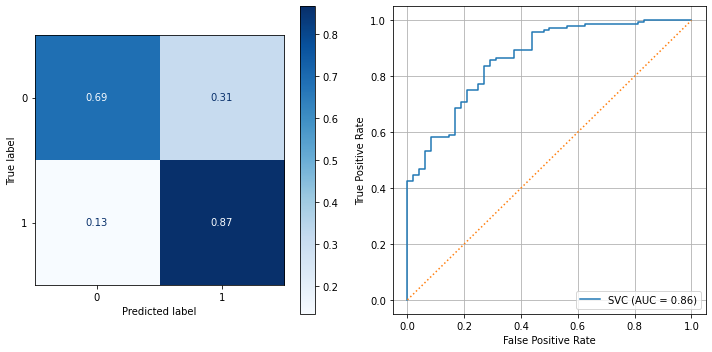

SVC(C=1, kernel='linear')

In [21]:
# tic = time() #timing!
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,*train_test_list)

___

# **⭐️Feature Selection Study Group⭐️**

- Office Hours for 022221FT
- 05/18/21

## Types  of Feature Selection

- Filter Methods.
- Wrapper Methods.
- Embedded Methods.


### Filter Methods

> Filter methods: rely on the characteristics of the features themselves. Does not involve machine learning models. Ideal for quick screen and removal of irrelevant features.

- Advantages:
    - Model agnostic
    - Less computationally expensive than other methods. 
  
    
- Disadvantages:
    - Lower improvement in model performance vs other methods. 


- Example Filter Methods:
    - Variance
    - Correlation
    - Univariate selection

### Wrapper Methods

> Wrapper methods use predictive machine learning models to score various subsets of features. Train a new model for each feature subset.

- Advantages:
    -  Provides the best performing subset for given model type.
    
- Disadvantages:
    -  Very computationally expensive
    - May not produce best feature combos for different methods.
    
- Example Wrapper Methods:
    - Forward selection
    - Backward elimination
    - Exhaustive Search


### Embedded Methods

> Embedded methods performs feature selection as part of the modeling/training process.

- Advantages:
    -  Consider the interactions between features and models.
    - Less computationally expensive than Wrapper methods (only fit the model 1 time vs many)
    
- Disadvantages:
    - only available in some models.
    - selected features may not always be appropriate for different model types
    
- Example Embedded Methods:
    - Lasso Regression
    - Tree importance

## Using Filter Methods

- Overall Filter Methods Process:
    1. Rank each feature according to some criterion
    2. Select features with highest ranking. 
- Example Filter Methods (used below):
    1. Variance Threshold
    2. Correlation
    3. Mutual Information
    4. Univariate Models

### FM1: Finding Constant & Quasi-Constant Features with `VarianceThreshold`

- `VarianceThreshold`:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

- Constant Features have the same value for every observation.
- Quasi-Constant Features have 95-98% of the same value for one feature. 

- Using sklearn's VarianceThreshold with either `threshold=0.0` for constant features or `threshold=0.01` for quasi-constant

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_sm)

In [ ]:
## get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features.sum()

In [ ]:
keep_features.shape, X_train_sm.shape

In [ ]:
# ### SAVING XY DATA TO LIST TO UNPACK
# train_test_list = [X_train_sm,X_test_df,y_train_sm,y_test]

In [ ]:
X_train_var = X_train_sm.loc[:,keep_features]
X_test_var = X_test_df.loc[:,keep_features]
X_train_var

In [ ]:
# tic = time() #timing!
svc_linear = SVC(kernel='linear',C=1)
pf.fit_and_time_model(svc_linear,X_train_var,y_train_sm,X_test_var,y_test)

### FM2: Using Correlation to identify & remove highly-correlated features

In [ ]:
def get_list_of_corrs(df,drop=[],
                      cutoff=0.75,only_above_cutoff=False,
                     sort_by_col=False):
    ## Claculate correlation and convert to 3-column table.
    corr_df = df.drop(drop,axis=1).corr().unstack().reset_index()
    
    ## Remove self-correlations
    corr_df = corr_df.loc[ corr_df['level_0']!=corr_df['level_1']]
    
    ## Make one column with unique names and drop duplicate pairs of cols
    corr_df['columns'] = corr_df.apply(
        lambda row: '_'.join(set(row[['level_0','level_1']] )), axis=1)
    corr_df.drop_duplicates(subset=['columns'],inplace=True)
    
    ## Rename Columns
    corr_df.rename({0:'r-value','level_0':'Column1',
               'level_1':'Column2'},axis=1,inplace=True)     

    ## Check if above cutoff 
    corr_df['above_cutoff'] = corr_df['r'] > cutoff
 
    ## Sort by col or by r-value
    if sort_by_col:
        corr_df = corr_df.sort_values( ['Column1','Column2'],ascending=True)
    else:
        corr_df =  corr_df.sort_values('r',ascending=False)
        
    
    ## Return only those above cutoff
    if only_above_cutoff:
        corr_df = corr_df[corr_df['above_cutoff']==True]
        
    ## Reset Index for Aesthetics
    corr_df.reset_index(drop=True)
    return corr_df.round(2)

In [ ]:
# corr_df = get_list_of_corrs(df,cutoff=0.75, only_above_cutoff=True)
# corr_df.head()

### FM3: Using Mutual Information

> [Wikipedia: Mutual Infromation](https://en.wikipedia.org/wiki/Mutual_information)

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [ ]:
# calculate the mutual information between the variables and the target

# the smaller the value of the mi, the less information we can infer from
# the feature about the target

mi = mutual_info_classif(X_train_sm, y_train_sm)
mi

In [ ]:
## Make a series so we can see which features
mi_scores = pd.Series(mi,index=X_train_sm.columns).sort_values(ascending=False)
mi_scores = mi_scores.to_frame('MI')
mi_scores

> How many features to keep is somewhat arbitrary.
- Can use `SelectKBest` to select top `K` m.i. features 
- Can use `SelectPercentile` to select top %


In [ ]:
k = 100
top_k_selector = SelectKBest(mutual_info_classif,k=k).fit(X_train_sm,y_train_sm)
top_k_columns = X_train_sm.columns[top_k_selector.get_support()]
top_k_columns

#### FM4: Univariate Models 

- While not demo'd in this notebook,an example univariate modeling approach would be to take all of the features of a house one at a time to make separate simple linear regression models. 
- Then, select the top K features that had the good performance (R-Squared).

## Using Wrapper Methods

- Overall Wrapper Methods Process:
    - Use a specific classifier to select the optimal number of features. 
    - General approach is to create many recursive models where a feature is added or removed from the dataset and the performance is scored. 
    - Greedy search algorithms (will try all options)

___

- Example Wrapper Methods (used below):
    1. Stepwise Forward Selection 
    2. Stepwise Backward Selection/Recursive Feature Elimination. 
    
    3. Exhaustive Feature Selection

### WM1&2: Stepwise Forward/Backwards Selection with `mlxtend`'s `SequentialFeatureSelector`

- [mlxtend Sequential Feature Selector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector

- To use SFS, must provide:
    1. Make an instance of the model you wish to optimize for (e.g. Random Forests, SVC)
    2. Choose a stopping criterion (e.g. select 10 features).
    3. Specify if want to step forward or backward. 
    4. Evaluation metric to use
    5. Cross validation

In [ ]:
# svc_linear = SVC(kernel='linear',C=1)
sfs = SequentialFeatureSelector( SVC(kernel='linear',C=1), k_features=25,
                               forward=True, floating=True,
                                verbose=2, cv=2,
                                n_jobs=-1)
sfs.fit(X_train_sm,y_train_sm)

In [ ]:
sfs.k_feature_idx_

In [ ]:
selected_features = X_train_sm.columns[list(sfs.k_feature_idx_)]
selected_features

### WM3: Exhaustive Feature Selection

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

## Using Embedded Methods

- Overall Embedded Methods Process:
    1. Train a machine learning model (Feature selection performed during the model's training. )
    2. Derive feature importance from the model
    3. Remove non-important features.
___

- Example Embedded Methods (used below):
    1. Regression Coefficients 
    2. Tree importance 
    3. LASSO/L1-Regularization


[i] Training started at 05/17/21-18:24:52:
	Training time was 0.8795 seconds.

           Train  Test  Difference
accuracy   1.00  0.87        0.13 

------------------------------------------------------------
	CLASSIFICATION REPORT - TEST DATA
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        48
           1       0.91      0.91      0.91       141

    accuracy                           0.87       189
   macro avg       0.83      0.83      0.83       189
weighted avg       0.87      0.87      0.87       189



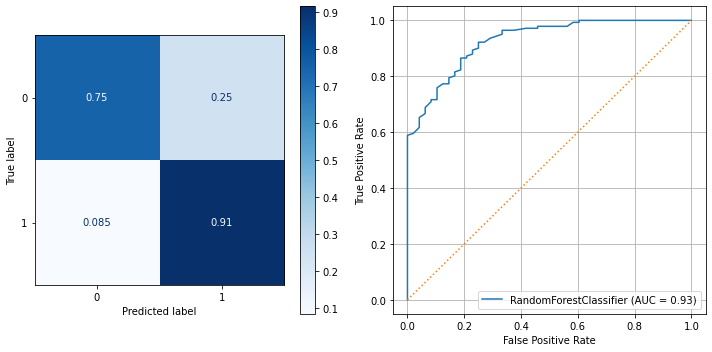

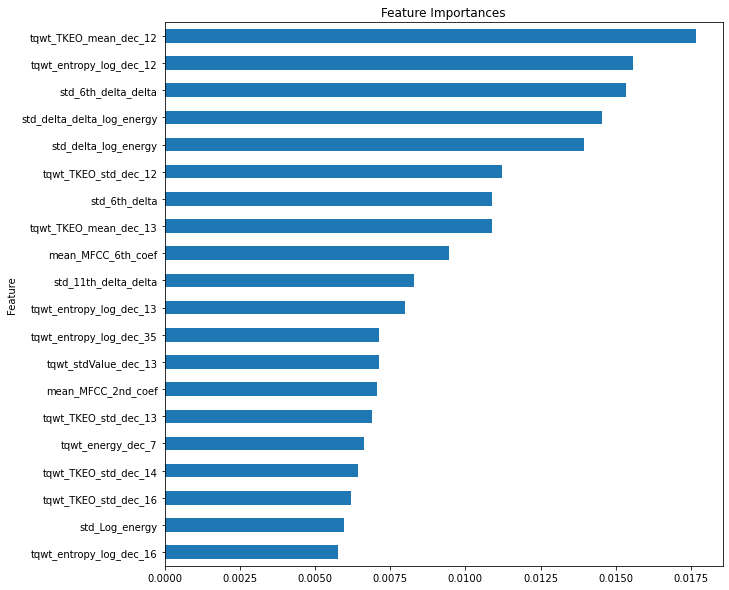

In [23]:
rf = RandomForestClassifier()
pf.fit_and_time_model(rf,*train_test_list)
importances = pf.get_importance(rf,X_train_df)

In [33]:
importances.sort_values(ascending=False)

tqwt_TKEO_mean_dec_12        0.02
tqwt_entropy_log_dec_12      0.02
std_6th_delta_delta          0.02
std_delta_delta_log_energy   0.01
std_delta_log_energy         0.01
                             ... 
std_12th_delta_delta         0.00
tqwt_skewnessValue_dec_1     0.00
tqwt_meanValue_dec_9         0.00
mean_4th_delta               0.00
gender_1                     0.00
Length: 753, dtype: float64

___
# iNTERPRET

In [ ]:
# from mlxtend 

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

# APPENDIX

In [ ]:
## Defining Clusters of related columns for EDA/preprocessing

feature_types = dict(patient_info = ['id','gender'], 
     baseline = ['Jitter', 'Shimmer','Harmonicity', 'RPDE','DFA',"PPE"],
     time_frequency = ['intensity'], 
     mel_spectrogram = ['MFCC'],
     tqwt = ['tqwt'])

feature_types

In [ ]:
## Quick test filter for stub names
# list(filter(lambda x: 'intensity' in x.lower(),df.columns))

In [ ]:
def make_feature_dict(df,feature_types):
    """Finds column names by recognizing name stubs (partial col names)
    
    Args:
        df (Frame): df with columns to filter.
        feature_types (dict): dict with category of features as the first key
        and a list of stub names of columns that belong to that category.
        
    Returns:
        feature_cols: dict of filtered columns grouped by "feature_types" keys.
        all_columns: list of all filtered columns without grouping.
        
        
    EXAMPLE USAGE:
    >>  feature_types = dict(patient_info = ['id','gender'], 
                        time_frequency = ['intensity'],
                        baseline = ['Jitter','Harmonicity'])
    >> feature_cols ,all_cols = make_feature_dict(df,feature_types)
    >> feature_cols
    ## RETURNS: 
    {'patient_info': ['id', 'gender'],
     'time_frequency': ['minIntensity', 'maxIntensity', 'meanIntensity'],
     'baseline': ['locPctJitter',
      'locAbsJitter',
      'rapJitter',
      'ppq5Jitter',
      'ddpJitter',
      'meanAutoCorrHarmonicity',
      'meanNoiseToHarmHarmonicity',
      'meanHarmToNoiseHarmonicity']}
        """
    ## create epty dict to fill in related features and empty list for all cols
    feature_cols = {}
    all_columns= []
    
    ## For each feature type and the list of stub names
    for feat_type, name_list in feature_types.items():
#         feature_cols[feat_type] = {}

        ## Maker a list to handle single-column results 
        curr_type_cols = []
        
        ## For each name stub
        for name in name_list:
            ## Get all columns containing stub
            cols = [c for c in df.columns if name.lower() in c.lower()]
            
            ## Add cols to both current type and all columns
            curr_type_cols.extend(cols)
            all_columns.extend(cols)
            
            ## save list of columns under feature_type
            feature_cols[feat_type] = curr_type_cols
            
            
            ### OLD CODE WHEN ORIGINALLY USING NESTED DICT
#             ## If the name 
#             if name.lower() == feat_type.lower():
#                 feature_cols[feat_type] = cols
                
#             else:
#                 ## combine names
#                 feature_cols[feat_type] = cols
                
            
            
    return feature_cols, all_columns


In [ ]:
## Saving dict of all identified clusters of features
feature_cols,filtered_cols = make_feature_dict(df,feature_types)
feature_cols.keys()

In [ ]:
## How many cols grabbed by function
len(filtered_cols)

In [ ]:
## testing feat_cols dict
feature_cols['baseline']

### BOOKMARK FOR LATER: Sorting out remaining cols to group/filter

In [ ]:
# df_unmatched = df.drop(columns=filtered_cols)
# df_unmatched.info()

### RandomForest

### RandomForest

In [ ]:
# rf = RandomForestClassifier()
# pf.fit_and_time_model(rf,*train_test_list)

In [ ]:
# pf.get_importance(rf,X_test_df,top_n=100);